# RAG on local device

1. Document preprocessing and embedding creation
2. Search and Answer

### 1. Document/text processing and embedding creation

In [1]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")
    
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    
    filename = pdf_path
    
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
        
else:
    print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [2]:
import fitz

from tqdm.auto import tqdm

def text_formatter(text:str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number":page_number-41,
                                "page_char_count":len(text),
                                "page_word_count":len(text.split(" ")),
                                "page_sentence_count_raw" : len(text.split(". ")),
                                "page_token_count":len(text) / 4,
                                "text":text})
        
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 116,
  'page_char_count': 999,
  'page_word_count': 165,
  'page_sentence_count_raw': 8,
  'page_token_count': 249.75,
  'text': 'water. Three electrolytes are more closely regulated than others:  Na+, Ca++, and K+. The kidneys share pH regulation with the lungs  and plasma buffers, so that proteins can preserve their three- dimensional conformation and thus their function.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.  These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    An interactive or media element has been  excluded fr

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(decimals=2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


#### Further text processing (splitting pages into sentences)

In [6]:
from spacy.lang.en import English

nlp = English()

# Add Sentencizer pipeline
nlp.add_pipe("sentencizer")

# Document instance example
doc = nlp("This is a sentence. This is another one. This is the last.")
assert len(list(doc.sents)) == 3

# Sentences split
list(doc.sents)

[This is a sentence., This is another one., This is the last.]

In [7]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 138,
 'page_sentence_count_raw': 9,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5. Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  | 

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # spaCy datatype to str
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 251,
  'page_char_count': 795,
  'page_word_count': 132,
  'page_sentence_count_raw': 6,
  'page_token_count': 198.75,
  'text': 'More Resources  Visit this online database to discover the glycemic indices  of foods. Foods are listed by category and also by low,  medium, or high glycemic index.  http://www.gilisting.com/  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.  These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    Digestion and Absorption of Carbohydrates  |  251',
  'sentences': ['More Resources  Visit this online data

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


In [11]:
# Chunking sentences into smaller groups

num_sentence_chunk_size = 10

# split lists of texts recursively into chunk size
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    
    item["num_chunks"] = len(item["sentence_chunks"])
    
    

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 455,
  'page_char_count': 1913,
  'page_word_count': 354,
  'page_sentence_count_raw': 19,
  'page_token_count': 478.25,
  'text': 'voyaging ancestors, making it a “go-to” for many paddlers as they  cross the Ka‘iwi Channel.  Energy is essential to life. Normal function of the human body  requires a constant input and output of energy to maintain life.  Various chemical components of food provide the input of energy to  the body. The chemical breakdown of those chemicals provides the  energy needed to carry out thousands of body functions that allow  the body to perform daily functions and tasks such as breathing,  walking up a flight of steps, and studying for a test.  Energy is classified as either potential or kinetic. Potential energy  is stored energy, or energy waiting to happen. Kinetic energy is  energy in motion. To illustrate this, think of an Olympic swimmer  standing at the pool’s edge awaiting the sound of the whistle to  begin the race. While he waits for

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


In [15]:
#random.sample(pages_and_texts, k=1)
import re

pages_and_chunks = []

# Split each chunk into its own item
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join sentences together into a paragraph-like structure (join the list of sentences into one paragraph)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        # joined_sentence_chunk = 
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        
        # Check stats about chunks
        chunk_dict["chunk_char_count"]  = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")]) # Crude word count
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars
        
        pages_and_chunks.append(chunk_dict)
        
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 891,
  'sentence_chunk': 'Energy and Macronutrients Adolescents have increased appetites due to increased nutritional requirements. Nutrient needs are greater in adolescence than at any other time in the life cycle, except during pregnancy. The energy requirements for ages fourteen to eighteen are 1,800 to 2,400 calories for girls and 2,000 to 3,200 calories for boys, depending on activity level. The extra energy required for physical development during the teenaged years should be obtained from foods that provide nutrients instead of “empty calories.”Also, teens who participate in sports must make sure to meet their increased energy needs. Older adolescents are more responsible for their dietary choices than younger children, but parents and caregivers must make sure that teens continue to meet their nutrient needs. For carbohydrates, the AMDR is 45 to 65 percent of daily calories (203–293 grams for 1,800 daily calories). Adolescents require more servings of grain tha

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


#### Filter chunks of text for short chunks

In [18]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"]<= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 28.5 | Text: The World Bank claims that a million deaths occur every year from anemia and that the majority of those Iron | 663
Chunk token count: 29.0 | Text: 2010). EH. Net Encyclopedia. http://eh.net/?s=History+of+Food+and+Drug+Regulatio Protecting the Public Health | 1011
Chunk token count: 11.0 | Text: 978 | Food Supplements and Food Replacements
Chunk token count: 28.75 | Text: Accessed September 22, 2017. Dietary, Behavioral, and Physical Activity Recommendations for Weight Management | 507
Chunk token count: 10.5 | Text: Accessed November 22, 2017. 676 | Selenium


In [19]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 547,
  'sentence_chunk': 'dose of vitamin K. This practice has basically eliminated vitamin K- dependent bleeding disorders in babies. Table 9.9 Dietary Sources of Vitamin K Food Serving Vitamin K (mcg) Percent Daily Value Broccoli ½ c. 160 133 Asparagus 4 spears 34 28 Cabbage ½ c. 56 47 Spinach ½ c. 27 23 Green peas ½ c. 16 13 Cheese 1 oz. 10 8 Ham 3 oz. 13 11 Ground beef 3 oz. 6 5 Bread 1 slice 1.1 <1 Orange 1 e. 1.3 1 Summary of Fat-soluble Vitamins Table 9.10 Fat-Soluble Vitamins Fat-Soluble Vitamins | 547',
  'chunk_char_count': 489,
  'chunk_word_count': 95,
  'chunk_token_count': 122.25}]

#### Embedding text chunks

In [21]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

# Create list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
"Sentences can be embedded one by one or in a list.",
"I like horses!"]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# Check embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding: [-3.44286375e-02  2.95328815e-02 -2.33643427e-02  5.57257496e-02
 -2.19098609e-02 -6.47062203e-03  1.02848457e-02 -6.57803863e-02
  2.29717735e-02 -2.61121057e-02  3.80420350e-02  5.61403222e-02
 -3.68746594e-02  1.52787790e-02  4.37020473e-02 -5.19723371e-02
  4.89479862e-02  3.58104147e-03 -1.29751097e-02  3.54387122e-03
  4.23262641e-02  3.52606587e-02  2.49402281e-02  2.99177002e-02
 -1.99382380e-02 -2.39752773e-02 -3.33367917e-03 -4.30450514e-02
  5.72014526e-02 -1.32517833e-02 -3.54477987e-02 -1.13935936e-02
  5.55561110e-02  3.61099187e-03  8.88527040e-07  1.14027122e-02
 -3.82229425e-02 -2.43548071e-03  1.51314372e-02 -1.32699206e-04
  5.00659943e-02 -5.50876483e-02  1.73444841e-02  5.00959158e-02
 -3.75959277e-02 -1.04463594e-02  5.08322380e-02  1.24861132e-02
  8.67377296e-02  4.64143082e-02 -2.10690107e-02 -3.90251614e-02
  1.99698494e-03 -1.42345531e-02 -1.86794791e-02  2.826691

In [22]:
embeddings[0].shape

(768,)

In [23]:
%%time


embedding_model.to("cuda")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 4.94 s, total: 1min 36s
Wall time: 12.2 s


In [24]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

len(text_chunks)

CPU times: user 1.98 ms, sys: 120 µs, total: 2.1 ms
Wall time: 267 µs


1680

In [25]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)

CPU times: user 25.5 s, sys: 1.39 s, total: 26.9 s
Wall time: 3.28 s


In [26]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [27]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02281553e-02 -5.09549258e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156232e-02 5.92139289e-02 -1.66167468e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801954e-02 3.39814052e-02 -2.06426717e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566836e-02 3.81275043e-02 -8.46853014e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49767029e-03 9.57159698e-...


## 2. RAG - Search and Answer

Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages


In [28]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (as it got converted to string when saved to CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x:np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings into torch.tensor
embeddings = torch.tensor(np.stack(arrays=text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding tf to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")


text_chunks_and_embeddings_df[:1]

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.0,"[0.0674242601, 0.0902281553, -0.00509549258, -..."


In [29]:
pages_and_chunks[:1]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0,
  'embedding': array([ 6.74242601e-02,  9.02281553e-02, -5.09549258e-03, -3.17545645e-02,
          7.39082173e-02,  3.51976156e-02, -1.97987109e-02,  4.67692763e-02,
          5.35727032e-02,  5.01232594e-03,  3.33929174e-02, -1.62218197e-03,
          1.76080782e-02,  3.62653807e-02, -3.16707330e-04, -1.07118469e-02,
          1.54257929e-02,  2.62176134e-02,  2.77653895e-03,  3.64942439e-02,
         -4.44109589e-02,  1.89361889e-02,  4.90117893e-02,  1.64020080e-02,
         -4.85782959e-02,  3.18291062e-03,  2.72992738e-02, -2.04758975e-03,
         -1.

In [30]:
embeddings.shape

torch.Size([1680, 768])

In [31]:
# Create model

from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

In [32]:
# 1.Define query
query = "macronutrients functions"
print(f"Query: {query}")

# 2.Embed query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3.Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
# : Sentence Transformer result is normalized, therefore here we can use dot product instead of cosine similarity
# : To use dot product for comparision, ensure vector sizes are of same shape (e.g.768) and tensors/vectors are in the same datatype (e.g. both torch.float32)
#   (as well as on same device)
from time import perf_counter as timer

start_time = timer()

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings:{end_time-start_time:.5f} seconds.")

# 4.Get top-k results (top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[INFO] Time taken to get scores on 1680 embeddings:0.00040 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [33]:
query_embedding.dtype

torch.float32

In [34]:
embeddings[0].dtype

torch.float32

In [35]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [36]:
# vector search example
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [37]:
query = "macronutrient functions"
print(f"Qeury: '{query}'\n")
print("Results:")

# Loop through zipped scores/indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Qeury: 'macronutrient functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are m

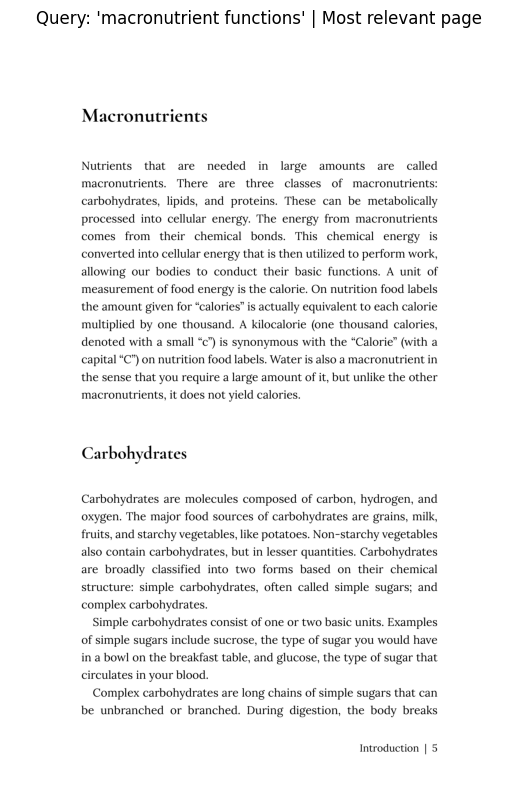

In [38]:
import fitz # pymupdf library
# open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5+41)

# Get image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert pixmap to numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))
                            # numpy get along well with uint8 values
                            
# img_array

# Display image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page")
plt.axis("off")
plt.show()


#### Similarity measures: dot product and cosine similarity

In [39]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)
    
    # Get Euclidean / L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    
    return dot_product / (norm_vector1*norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

# Calculate dot product

print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity

print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


#### Functionizing semantic search pipeline

In [40]:
def retrieve_relevant_resources(query:str,
                                embeddings:torch.tensor,
                                model:SentenceTransformer=embedding_model,
                                n_resources_to_return:int=5,
                                print_time:bool=True):
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # Get dot product scores of query embedding and embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
        
    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks:list[dict]=pages_and_chunks,
                                 n_resources_to_return:int=5):
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

    

In [41]:
query="foods high in fiber"
retrieve_relevant_resources(query=query,embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00004 seconds.
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in th

#### Getting LLM for local generation

In [42]:
# GPU memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Avail GPU mem : {gpu_memory_gb} GB")

Avail GPU mem : 24 GB


In [43]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Aug 14 09:34:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:2B:00.0  On |                  Off |
| 30%   42C    P2              62W / 380W |   2286MiB / 24564MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Loading LLM locally

1. Quantization config (optional)
2. Model ID - which model/tokenizer to load
3. Tokenizer - turns text into numbers (different from an embedding model)
4. LLM model - generate text based an input

*flash attention can boost tokenizer (speed up)

In [44]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
# google/gemma-7b-it
model_id = "google/gemma-7b-it"
use_quantization_config = False

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create Quantization config
# requires !pip install bitsandbytes accelerate (huggingface library)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16) # load in 4bit, compute in float16

# flash attention 2 (speeds up Transformer operations)
if (is_flash_attn_2_available) and (torch.cuda.get_device_capability(0)[0]):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention impl : {attn_implementation}")
    
# 2. pick a model to use
# model_id = "google/gemma-7b-it"
model_id = model_id

# 3. Instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

    

Using attention impl : flash_attention_2


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Aug 14 09:34:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:2B:00.0  On |                  Off |
| 30%   40C    P2              61W / 380W |  17668MiB / 24564MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [47]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gem

In [48]:
def get_model_num_params(model: torch.nn.Module):
    return "{:,}".format(sum(param.numel() for param in model.parameters()))

formatted_params = get_model_num_params(model=llm_model)
print(formatted_params)


8,537,680,896


In [51]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    
    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)
    
    return {"model_mem_bytes" :model_mem_bytes,
            "model_mem_mb" : round(model_mem_mb,2),
            "model_mem_gb" : round(model_mem_gb,2)}
    
get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}